In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2
import os
import glob
import matplotlib.pyplot as plt
import sys

In [2]:
### Append the project root directory to sys.path
sys.path.append(os.path.abspath("/Users/prashal/dev/Face-Detector"))

##### Define constants for model configuration

In [3]:
OUTPUT_SHAPE = (300, 300)
BATCH_SIZE = 32

##### Define custom functions

In [4]:
### Rescale bounding box annotations
def scale_bbxs(bbxs, org_img_shape, out_img_shape):
    org_height, org_width = org_img_shape
    new_height, new_width = out_img_shape
    scale_x = new_width / org_width
    scale_y = new_height / org_height
    scaled_bbxs = []
    for bbx in bbxs:
        x, y, w, h = [int(pt) for pt in bbx.split()]
        scaled_bbx = list(map(round, [scale_x * x, scale_y * y, scale_x * w, scale_y * h]))
        scaled_bbxs.append(scaled_bbx)
    return scaled_bbxs

### Define generator
def generator(data_path, image_bbxs, batch_size, output_shape):
    num_samples = len(image_bbxs)
    indices = np.arange(num_samples)
    image_names = list(image_bbxs.keys())
    bbxs = list(image_bbxs.values())
    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        batch_indices = indices[start_idx:end_idx]
        batch_images = []
        batch_labels = []
        for idx in batch_indices:
            image_path = os.path.join(data_path, image_names[idx])
            bgr = cv2.imread(image_path)
            img_shape = bgr.shape[:2]
            image = cv2.resize(bgr, output_shape)
            batch_images.append(image)
            ####
            image_bbxs = bbxs[idx]
            scaled_bbxs = scale_bbxs(image_bbxs, img_shape, output_shape)
            batch_labels.append(scaled_bbxs)
            ####
        yield (np.stack(batch_images), batch_labels)

##### Read training images and bounding box annotations

In [5]:
### Read bounding box annotations - training set
data_dir = "../wider_face/data"
with open(os.path.join(data_dir, "wider_face_split/wider_face_train_bbx_gt.txt"), "r") as file: 
    bbox_anno = [line.rstrip("\n, ") for line in file.readlines()]

In [6]:
### Create a dictionary such that it contains image_name:respective_annotations 
img_indices = []
n_bbxes = []
for i in range(len(bbox_anno)):
    if bbox_anno[i].endswith((".jpg", ".jpeg", ".png")):
        img_indices.append(i)
        n_bbxes.append(int(bbox_anno[i+1]))
annotations = {}
for idx,n in list(zip(img_indices, n_bbxes)):
    img_name = bbox_anno[idx]
    res_annot = bbox_anno[idx+2 : idx+2+n]
    ### Remove blur, expression, illumination, invalid, occlusion and pose details. Keep x1, y1, w and h.
    res_annot = [" ".join(annot.split()[:4]) for annot in res_annot]
    annotations[img_name] = res_annot

##### Display training images and bounding boxes

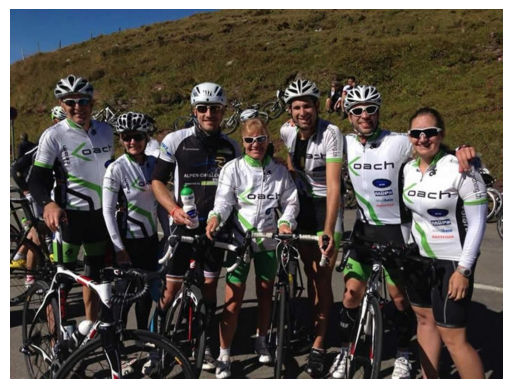

In [7]:
### Display random images from the training set
rand_n = np.random.randint(len(annotations))
img_name, bbxs = list(annotations.items())[rand_n]
bgr = cv2.imread(os.path.join(data_dir, "WIDER_train/images", img_name))
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
plt.imshow(rgb)
plt.axis("off")
plt.show()

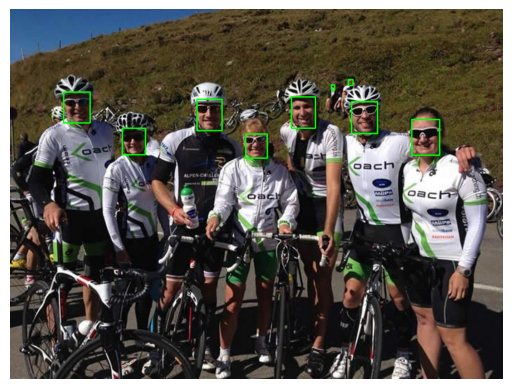

In [8]:
### Display bounding boxes
for annot in bbxs:
    x, y, w, h = [int(pt) for pt in annot.split()]
    cv2.rectangle(rgb, (x, y), (x+w, y+h), (0, 255, 0), 2)
plt.imshow(rgb)
plt.axis("off")
plt.show()

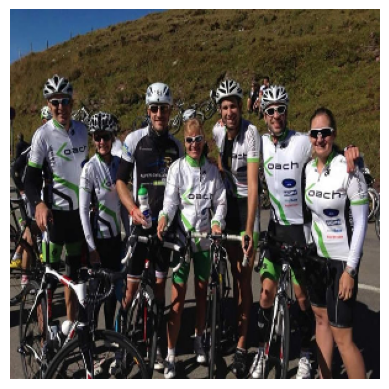

In [9]:
### Reshape images
bgr_ = cv2.imread(os.path.join(data_dir, "WIDER_train/images", img_name))
rgb_ = cv2.cvtColor(bgr_, cv2.COLOR_BGR2RGB)
resized_image = cv2.resize(rgb_, OUTPUT_SHAPE)
plt.imshow(resized_image)
plt.axis("off")
plt.show()

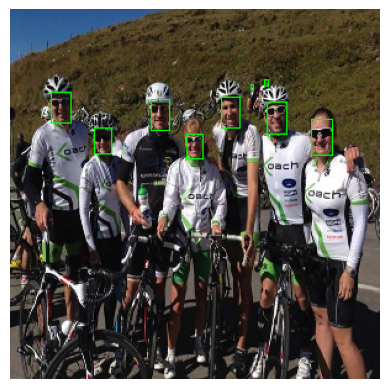

In [10]:
### Display rescaled bounding boxes
scaled_bbx = scale_bbxs(bbxs, rgb.shape[:2], OUTPUT_SHAPE)
for bbx in scaled_bbx:
    x, y, w, h = bbx
    cv2.rectangle(resized_image, (x, y), (x+w, y+h), (0, 255, 0), 1)
plt.imshow(resized_image, )
plt.axis("off")
plt.show()

##### Preprocessing

In [11]:
### Split the dataset into train, validation and test sets
from sklearn.model_selection import train_test_split
data = list(annotations.items()) # Convert the dictionary to a list of key-value pairs
train, test = train_test_split(data, train_size=0.5)
train, val = train_test_split(train, train_size=0.8)
train_annotations = dict(train) # Convert the list of key-value pairs back to a dictionary
test_annotations = dict(test)
val_annotations = dict(val)

In [12]:
train_gen = generator(os.path.join(data_dir, "WIDER_train/images"), train_annotations, batch_size=BATCH_SIZE, output_shape=OUTPUT_SHAPE)
val_gen = generator(os.path.join(data_dir, "WIDER_train/images"), val_annotations, batch_size=BATCH_SIZE, output_shape=OUTPUT_SHAPE)

##### Define model configuration parameters